### Student Information
Name: 許恩嘉

Student ID: 113065530

GitHub ID: 92287531

---

### Instructions

1. First: do the **take home** exercises in the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git). You may need to copy some cells from the Lab notebook to this notebook. __This part is worth 20% of your grade.__


2. Second: follow the same process from the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git) on **the new dataset**. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 30% of your grade.__
    - Download the [the new dataset](https://huggingface.co/datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data). The dataset contains a `sentiment` and `comment` columns, with the sentiment labels being: 'nostalgia' and 'not nostalgia'. Read the specificiations of the dataset for background details. 
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Scikit-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Note that for the TF-IDF features you might need to use other type of NB classifier different than the one in the Master Notebook. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be handled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 10% of your grade.__


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/didiersalazar/DM2024-Lab1-Master/blob/main/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb). Make sure to commit and save your changes to your repository __BEFORE the deadline (October 27th 11:59 pm, Sunday)__. 

### Begin Assignment Here

In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### import some function and load data

In [117]:
import pandas as pd
import numpy as np

import data_mining_helpers as dmh

import nltk
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from PAMI.extras.DF2DB import DenseFormatDF as db
from PAMI.extras.dbStats import TransactionalDatabase as tds
from PAMI.frequentPattern.basic import FPGrowth as alg

import math

import warnings

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.preprocessing import binarize
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

from scipy.spatial.distance import pdist, squareform

# for TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

import umap

warnings.filterwarnings("ignore")

In [118]:
# load dataset
# it's a data frame

df = pd.read_csv("hf://datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv")

### do some EDA

In [119]:
df.head()

,sentiment,comment
0,not nostalgia,He was a singer with a golden voice that I lov...
1,nostalgia,The mist beautiful voice ever I listened to hi...
2,nostalgia,I have most of Mr. Reeves songs. Always love ...
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...
4,nostalgia,listening to his songs reminds me of my mum wh...


In [120]:
# check the unique value of sentiment columns

df.sentiment.unique()

array(['not nostalgia', 'nostalgia'], dtype=object)

In [121]:
# check whether there's newline character or not

df[df["comment"].apply(lambda x: "\n" in x)]

,sentiment,comment


In [122]:
# print the first three element of comment column
for text in df.comment[:3]:
    print(text)
    print('-')

He was a singer with a golden voice that I love to hear all the time. I was his great fan at the age of 16years in those days and still now. Although we have many singers now, but, I can vouch for Jim Reeves all the time. You feel relaxed, emotional and loving. Thank you Lord for his life.
-
The mist beautiful voice ever I listened to him when I was a kid and still love his singing Never forgotten The voice of an angel
-
I have most of Mr. Reeves songs.  Always love his smooth voice, so comforting and sounds like the people I grew up around.  They were so gentle and sweet, but I had to leave my little town to find a job at age 17.  I graduated early.  I never forgot how great it was to grow up with simple people who had no pretensions -- just loving and gentle, like I think Jesus is.
-


In [123]:
# this is the copy of data mining helpers

def format_rows(docs):
    """ format the text field and strip special characters """
    D = []
    for d in docs.comment:
        temp_d = " ".join(d.split("\n")).strip('\n\t')
        D.append([temp_d])
    return D

X = pd.DataFrame.from_records(dmh.format_rows(df), columns= ['text'])
X["sentiment"] = df["sentiment"]
X =  X[["sentiment", "text"]]
X

,sentiment,text
0,not nostalgia,He was a singer with a golden voice that I lov...
1,nostalgia,The mist beautiful voice ever I listened to hi...
2,nostalgia,I have most of Mr. Reeves songs. Always love ...
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...
4,nostalgia,listening to his songs reminds me of my mum wh...
...,...,...
1495,not nostalgia,"i don't know!..but the opening of the video,....."
1496,not nostalgia,it's sad this is such a beautiful song when yo...
1497,not nostalgia,"Dear Friend, I think age and time is not that ..."
1498,nostalgia,I was born in 1954 and started to be aware of ...


In [124]:
# do some static method to check whether there is missing value

print(X.isnull().apply(lambda x: dmh.check_missing_values(x)))

print('-')

print(X.isnull().apply(lambda x: dmh.check_missing_values(x), axis = 1))

                            sentiment                                text
0  The amoung of missing records is:   The amoung of missing records is: 
1                                   0                                   0
-
0       (The amoung of missing records is: , 0)
1       (The amoung of missing records is: , 0)
2       (The amoung of missing records is: , 0)
3       (The amoung of missing records is: , 0)
4       (The amoung of missing records is: , 0)
                         ...                   
1495    (The amoung of missing records is: , 0)
1496    (The amoung of missing records is: , 0)
1497    (The amoung of missing records is: , 0)
1498    (The amoung of missing records is: , 0)
1499    (The amoung of missing records is: , 0)
Length: 1500, dtype: object


In [125]:
# check duplicated data
print(X.duplicated())

print('-')

print("重複的資料（考慮兩個 col）有:", sum(X.duplicated()), "個")

print('-')

print("重複的資料（考慮text col）有:", sum(X['text'].duplicated()), "個")# 有重複的 text

print('-')

print("重複的資料（考慮sentiment col）有:", sum(X['sentiment'].duplicated()), "個")

duplicate_texts = X[X.duplicated(subset=['text'])]

# unique the duplicate value
duplicate_texts_unique = duplicate_texts['text'].unique()

# print the text of duplicated row to check
filtered = X[X['text'].isin(duplicate_texts_unique)]

print(filtered)

0       False
1       False
2       False
3       False
4       False
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Length: 1500, dtype: bool
-
重複的資料（考慮兩個 col）有: 1 個
-
重複的資料（考慮text col）有: 1 個
-
重複的資料（考慮sentiment col）有: 1498 個
        sentiment                                               text
62  not nostalgia  never heard this song before... WOW What an am...
78  not nostalgia  never heard this song before... WOW What an am...


In [126]:
# drop the duplicated row and keep the first row
# remember to reset the index
X = X.drop_duplicates(subset = ['text'], keep = 'first', ignore_index = True)

In [127]:
X_sample = X.sample(n = 500)
print("sample 資料數量:", len(X_sample))

print("sample 前十筆資料量:\n", X_sample[:10])

sample 資料數量: 500
sample 前十筆資料量:
           sentiment                                               text
1417  not nostalgia  Twitter is such a powerful media source!! The ...
1064      nostalgia  This is one of my most favorite songs for year...
580   not nostalgia  Scary Story, My Nana's best friend when she wa...
775       nostalgia                Evokes many happy memories, thanks.
723   not nostalgia                     I would love you if you let me
23    not nostalgia  He is the best there was best there ever will ...
977       nostalgia  back to my childhood to hear this song beside ...
504   not nostalgia  Dinah Shore  -- and --  Mitch Miller's Sing Al...
872   not nostalgia  Thank god for my parents wow i wish my gen of ...
963       nostalgia  When I am in Kindergarten, Teacher play this s...


### data visulization

sentiment
nostalgia        750
not nostalgia    749
Name: count, dtype: int64


<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

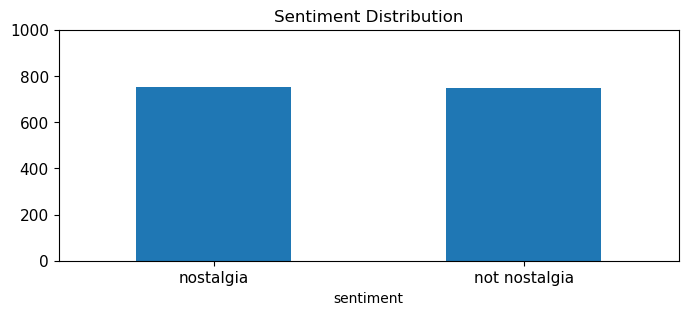

In [128]:
# visualize the sentiment distribution of the dataset

print(X.sentiment.value_counts())

# plot barchart for X
X.sentiment.value_counts().plot(kind = 'bar',
                                    title = 'Sentiment Distribution',
                                    ylim = [0, 1000],        
                                    rot = 0, fontsize = 11, figsize = (8,3))

sentiment
not nostalgia    261
nostalgia        239
Name: count, dtype: int64


<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

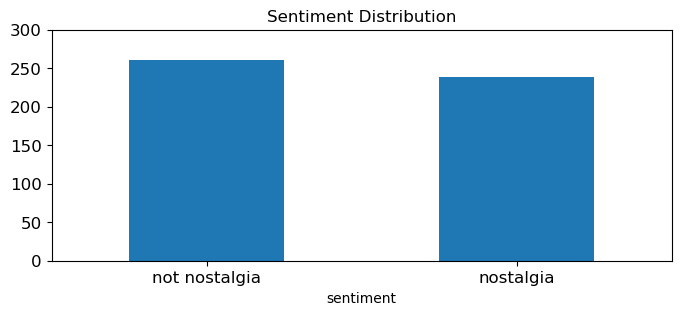

In [129]:
# visualize the sentiment distribution of the sampling data

print(X_sample.sentiment.value_counts())

# plot barchart for X_sample
X_sample.sentiment.value_counts().plot(kind = 'bar',
                                           title = 'Sentiment Distribution',
                                           ylim = [0, 300], 
                                           rot = 0, fontsize = 12, figsize = (8,3))

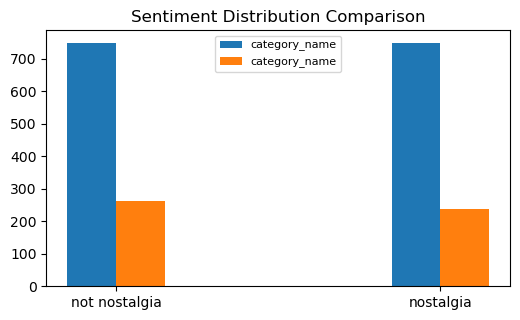

In [130]:
# compare the distribution of sampling data and full dataset

sentiment_X = X['sentiment'].value_counts()
sentiment_X_sample = X_sample['sentiment'].value_counts()

all_sentiment = sorted(set(sentiment_X.index) | set(sentiment_X_sample.index), reverse = True)

fig, ax = plt.subplots(figsize=(5.3, 3.3))

bar_width = 0.15
r1 = np.arange(len(all_sentiment))
r2 = [x + bar_width for x in r1]

bars1 = ax.bar(r1, [sentiment_X.get(cat, 0) for cat in all_sentiment], width=bar_width, label='category_name')
bars2 = ax.bar(r2, [sentiment_X_sample.get(cat, 0) for cat in all_sentiment], width=bar_width, label='category_name')

plt.title('Sentiment Distribution Comparison')

plt.xticks([r + bar_width/2 for r in range(len(all_sentiment))], all_sentiment, rotation=0)

plt.legend(loc='upper center', fontsize = 8)

plt.tight_layout()
plt.show()

In [131]:
# Apply the 'tokenize_text' function from the 'dmh' module to the 'text' column in the DataFrame 'X'.
# The result is assigned to a new column 'unigrams', which will contain the tokenized unigrams (individual words) from the 'text' column.

X['unigrams'] = X['text'].apply(lambda x: dmh.tokenize_text(x))

In [132]:
print("前四個 text 經過切詞後的結果:\n", X[0:4]['unigrams'], '\n')

print("透過 list 將切詞後結果包起來:\n", list(X[0:1].unigrams))

前四個 text 經過切詞後的結果:
 0    [He, was, a, singer, with, a, golden, voice, t...
1    [The, mist, beautiful, voice, ever, I, listene...
2    [I, have, most, of, Mr., Reeves, songs, ., Alw...
3    [30, day, leave, from, 1st, tour, in, Viet, Na...
Name: unigrams, dtype: object 

透過 list 將切詞後結果包起來:
 [['He', 'was', 'a', 'singer', 'with', 'a', 'golden', 'voice', 'that', 'I', 'love', 'to', 'hear', 'all', 'the', 'time', '.', 'I', 'was', 'his', 'great', 'fan', 'at', 'the', 'age', 'of', '16years', 'in', 'those', 'days', 'and', 'still', 'now', '.', 'Although', 'we', 'have', 'many', 'singers', 'now', ',', 'but', ',', 'I', 'can', 'vouch', 'for', 'Jim', 'Reeves', 'all', 'the', 'time', '.', 'You', 'feel', 'relaxed', ',', 'emotional', 'and', 'loving', '.', 'Thank', 'you', 'Lord', 'for', 'his', 'life', '.']]


In [133]:
# count the frequency of terms

count_vect = CountVectorizer()

X_counts = count_vect.fit_transform(X.text)

print("term document matrix shape is: ", X_counts.shape)

print(X_counts[0])

analyze = count_vect.build_analyzer()
print("第一個文本:\n", analyze(X.text[0]))

term document matrix shape is:  (1499, 3730)
  (0, 1598)	1
  (0, 3570)	2
  (0, 2973)	1
  (0, 3650)	1
  (0, 1470)	1
  (0, 3534)	1
  (0, 3282)	1
  (0, 2028)	1
  (0, 3336)	1
  (0, 1606)	1
  (0, 233)	2
  (0, 3284)	3
  (0, 3328)	2
  (0, 1651)	2
  (0, 1512)	1
  (0, 1249)	1
  (0, 323)	1
  (0, 214)	1
  (0, 2341)	1
  (0, 15)	1
  (0, 1733)	1
  (0, 3304)	1
  (0, 907)	1
  (0, 258)	2
  (0, 3124)	1
  (0, 2328)	2
  (0, 245)	1
  (0, 3581)	1
  (0, 1591)	1
  (0, 2082)	1
  (0, 2974)	1
  (0, 573)	1
  (0, 593)	1
  (0, 3538)	1
  (0, 1347)	2
  (0, 1833)	1
  (0, 2671)	1
  (0, 3713)	2
  (0, 1272)	1
  (0, 2688)	1
  (0, 1125)	1
  (0, 2035)	1
  (0, 3278)	1
  (0, 2018)	1
  (0, 1964)	1
第一個文本:
 ['he', 'was', 'singer', 'with', 'golden', 'voice', 'that', 'love', 'to', 'hear', 'all', 'the', 'time', 'was', 'his', 'great', 'fan', 'at', 'the', 'age', 'of', '16years', 'in', 'those', 'days', 'and', 'still', 'now', 'although', 'we', 'have', 'many', 'singers', 'now', 'but', 'can', 'vouch', 'for', 'jim', 'reeves', 'all', 'the'

In [134]:
# print some count_vect element to check
print("編號 3284 的 token 是:", count_vect.get_feature_names_out()[3284])
print("編號 1598 的 token 是:", count_vect.get_feature_names_out()[1598])
print("編號 258 的 token 是:", count_vect.get_feature_names_out()[258])
print("編號 3713 的 token 是:", count_vect.get_feature_names_out()[3713])
print("編號 3570 的 token 是:", count_vect.get_feature_names_out()[3570])

編號 3284 的 token 是: the
編號 1598 的 token 是: he
編號 258 的 token 是: and
編號 3713 的 token 是: you
編號 3570 的 token 是: was


In [135]:
# print a X_counts vector, which size is 5 * 100 and check the value

X_counts[0:5, 0:100].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

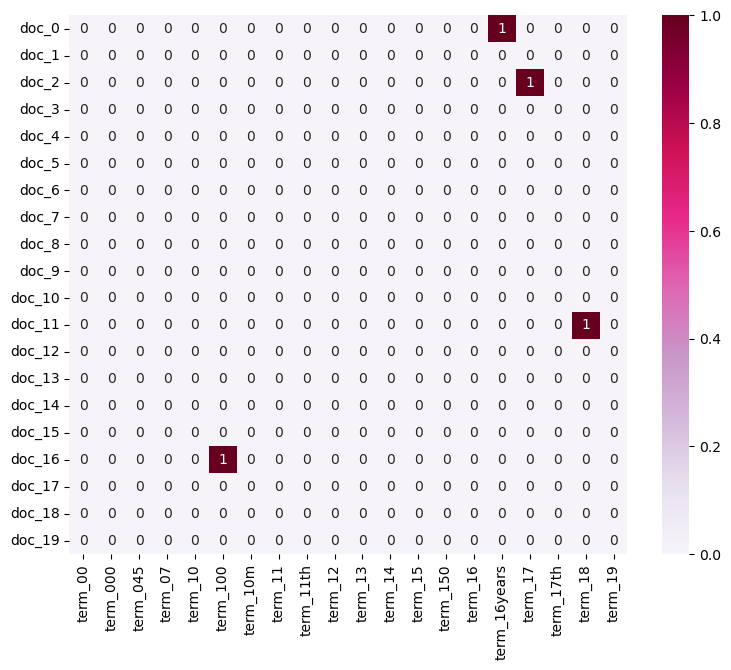

In [136]:
# heatmap
# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[0:20]]

# obtain document index
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]

plot_z = X_counts[0:20, 0:20].toarray() #X_counts[how many documents, how many terms]
plot_z

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andyhsu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/andyhsu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/andyhsu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


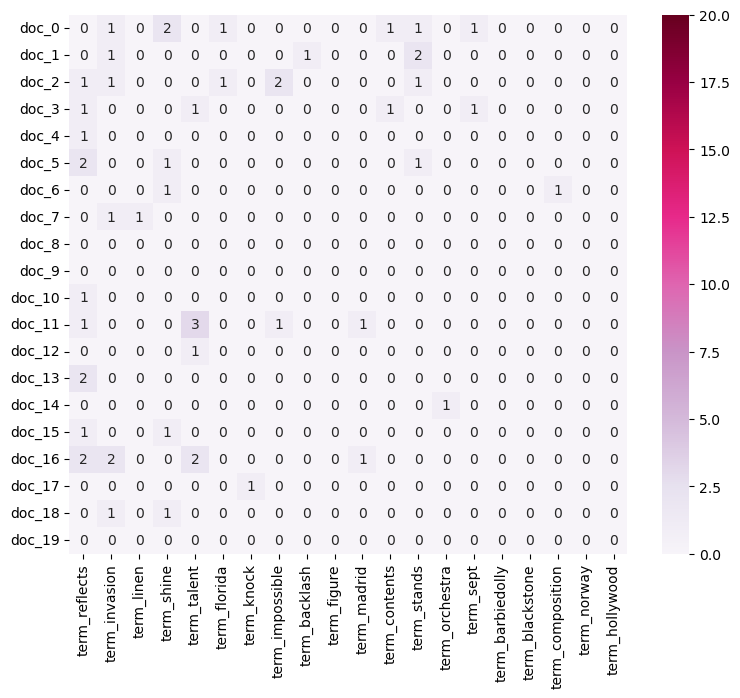

In [137]:
# improve the visulization of heatmap

# use stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

def lemmatize_text_nltk(text):
    tokens = nltk.word_tokenize(text)  # do tokenize
    # remove stop words and do some lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

# apply element in text column to lemmatize_text_nltk and create a new col named lemmatized_text
X['lemmatized_text'] = X['text'].apply(lemmatize_text_nltk)

count_vect_stop_words = CountVectorizer(stop_words = "english")
X_counts_stop_words = count_vect_stop_words.fit_transform(X['lemmatized_text']) #learn the vocabulary and return document-term matrix

dense_X = X_counts_stop_words.toarray()

# calculate the std of each column
std_values = np.std(dense_X, axis=0)

# sort col by std form high to low
sorted_indices = np.argsort(-std_values)
sorted_X = dense_X[:, sorted_indices]

hotMap = pd.DataFrame(sorted_X, columns = sorted_indices)

# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[sorted_indices[0:20]]]

# obtain document index
plot_y = ["doc_"+ str(i) for i in list(hotMap.index)[0:20]]

plot_z = sorted_X[0:20, 0:20] #X_counts[how many documents, how many terms]

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=20, annot=True)

In [138]:
# count the frequency of each term in corpus

term_frequencies = []

for j in range(0,X_counts.shape[1]):
    term_frequencies.append(sum(X_counts[:,j].toarray()))

print("term_frequencies:\n", term_frequencies)

term_frequencies = np.asarray(X_counts.sum(axis=0))[0]

term_frequencies:
 [array([1]), array([2]), array([1]), array([2]), array([16]), array([5]), array([1]), array([8]), array([1]), array([11]), array([8]), array([15]), array([10]), array([2]), array([12]), array([1]), array([13]), array([1]), array([9]), array([6]), array([1]), array([1]), array([1]), array([1]), array([3]), array([2]), array([4]), array([1]), array([1]), array([1]), array([2]), array([5]), array([3]), array([2]), array([12]), array([1]), array([3]), array([10]), array([3]), array([2]), array([2]), array([5]), array([3]), array([7]), array([2]), array([1]), array([4]), array([3]), array([2]), array([7]), array([1]), array([2]), array([2]), array([4]), array([6]), array([2]), array([1]), array([1]), array([1]), array([1]), array([1]), array([2]), array([5]), array([11]), array([1]), array([1]), array([2]), array([2]), array([1]), array([1]), array([2]), array([2]), array([1]), array([8]), array([25]), array([1]), array([1]), array([1]), array([3]), array([1]), array([1])

In [139]:
# check wheter term_frequencies is correct
# 看 first_term of array 是否全部出現一次

first_term = 0

for x in X_counts.toarray():
    first_term += x[0]

print(first_term)

1


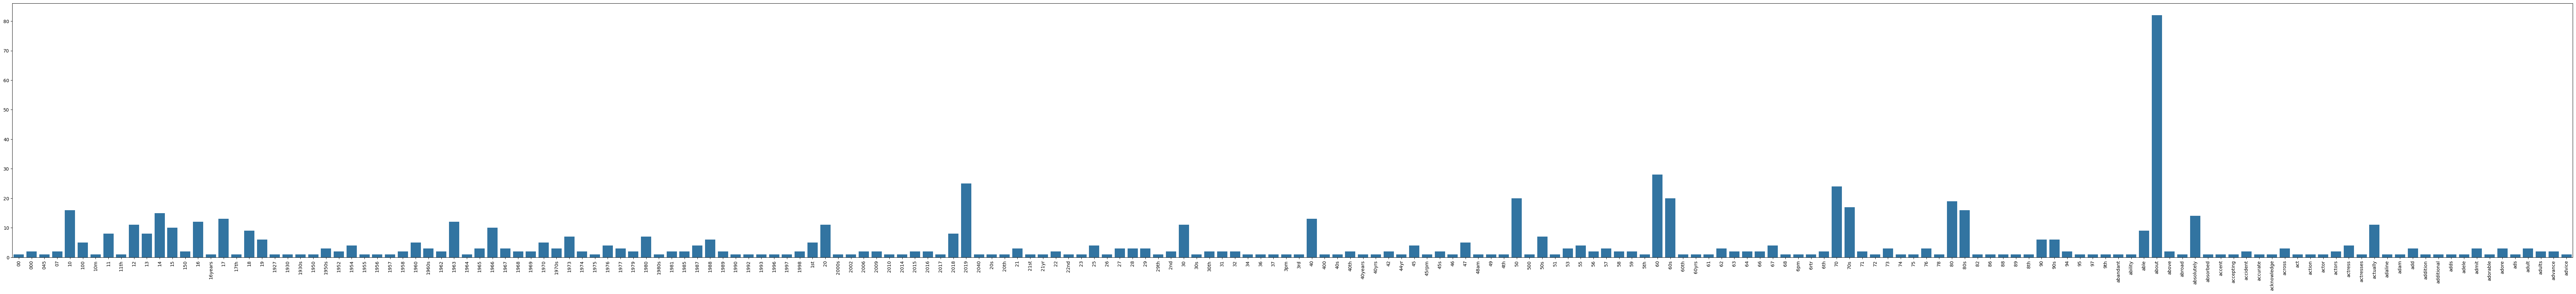

In [140]:
# matplotlib
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:200], 
            y=term_frequencies[:200])
g.set_xticklabels(count_vect.get_feature_names_out()[:200], rotation = 90);

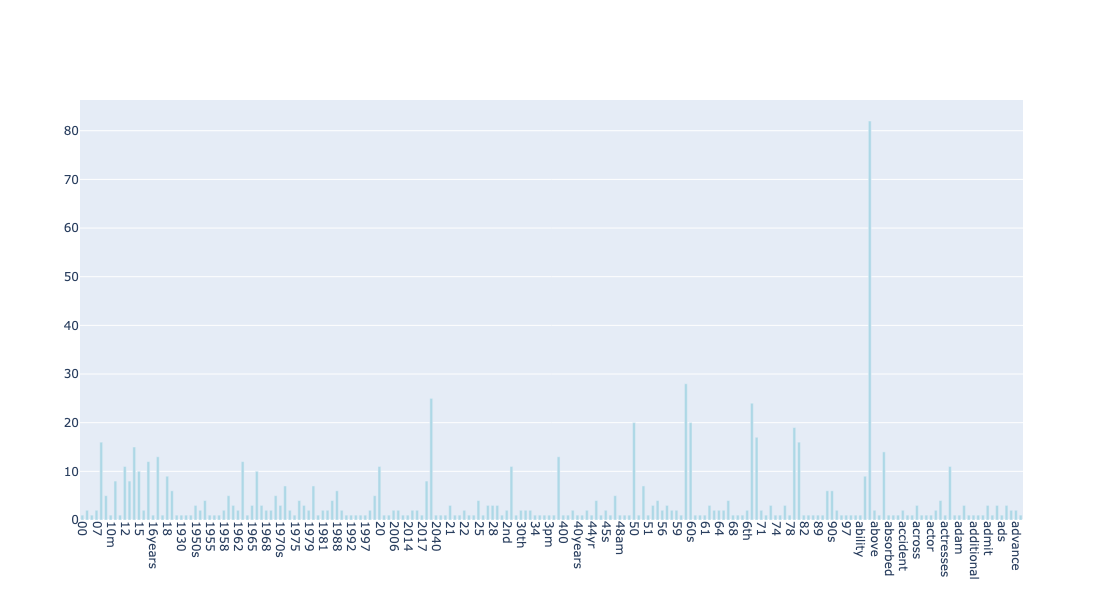

In [141]:
# for interactive plot

df = pd.DataFrame({
    'words': count_vect.get_feature_names_out()[:200],
    'frequencies': term_frequencies[:200]
})

df = df.sort_values('words', ascending=True)

fig = go.Figure(data=[go.Bar(
    x=df['words'],
    y=df['frequencies'],
    hoverinfo='x+y',
    marker_color='lightblue'
)])

fig.update_layout(
    xaxis_tickangle=90,
    height=600,
    width=1200,
    bargap=0.4
)

fig.show()

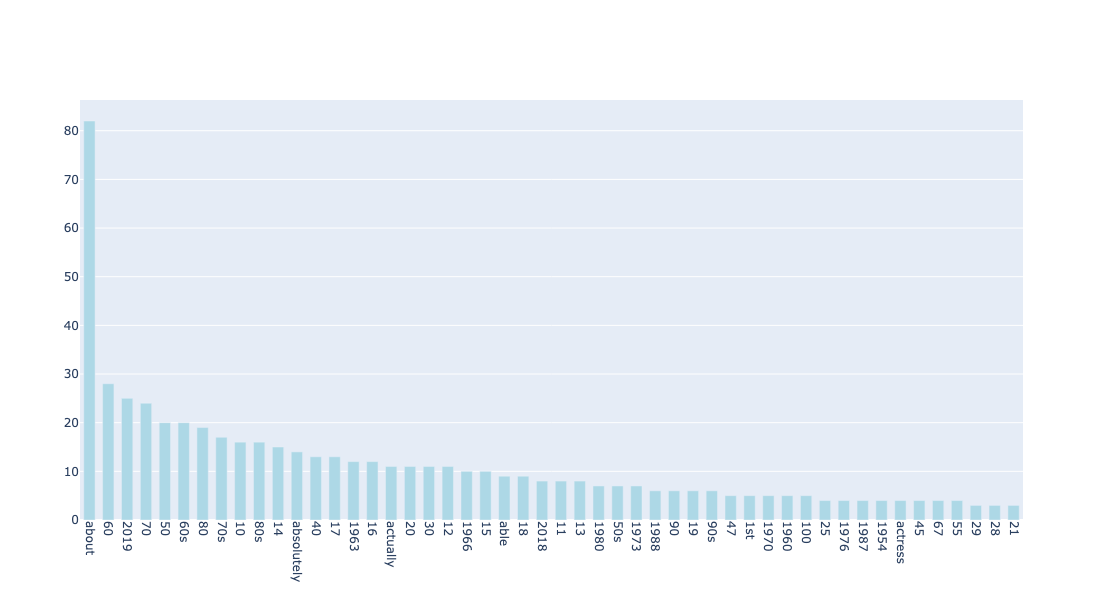

In [142]:
# sort by frequencies and reduce the number of terms to show

df = pd.DataFrame({
    'words': count_vect.get_feature_names_out()[:200],
    'frequencies': term_frequencies[:200]
})

df = df.sort_values('frequencies', ascending=False)

df = df.iloc[:int(len(df) * 0.25), :]

fig = go.Figure(data=[go.Bar(
    x=df['words'],
    y=df['frequencies'],
    hoverinfo='x+y',
    marker_color='lightblue'
)])

fig.update_layout(
    xaxis_tickangle=90,
    height=600,
    width=1200,
    bargap=0.4
)

fig.show()

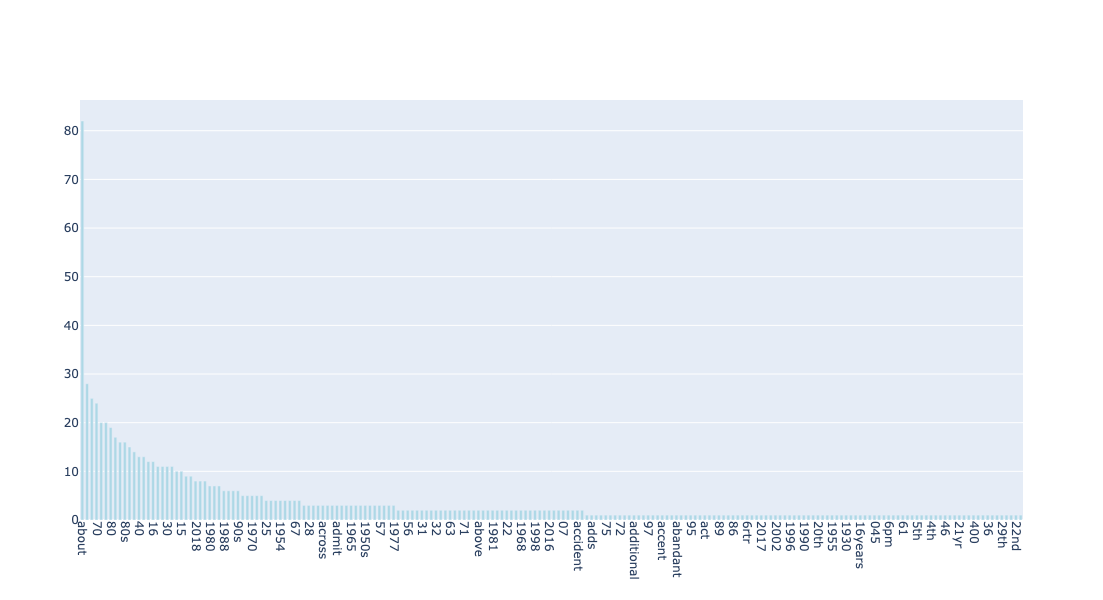

In [143]:
# sort by frequencies

df = pd.DataFrame({
    'words': count_vect.get_feature_names_out()[:200],
    'frequencies': term_frequencies[:200]
})

df = df.sort_values('frequencies', ascending=False)

fig = go.Figure(data=[go.Bar(
    x=df['words'],
    y=df['frequencies'],
    hoverinfo='x+y',
    marker_color='lightblue'
)])

fig.update_layout(
    xaxis_tickangle=90,
    height=600,
    width=1200,
    bargap=0.4
)

fig.show()

[Text(0, 0, '00'),
 Text(1, 0, '000'),
 Text(2, 0, '045'),
 Text(3, 0, '07'),
 Text(4, 0, '10'),
 Text(5, 0, '100'),
 Text(6, 0, '10m'),
 Text(7, 0, '11'),
 Text(8, 0, '11th'),
 Text(9, 0, '12'),
 Text(10, 0, '13'),
 Text(11, 0, '14'),
 Text(12, 0, '15'),
 Text(13, 0, '150'),
 Text(14, 0, '16'),
 Text(15, 0, '16years'),
 Text(16, 0, '17'),
 Text(17, 0, '17th'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '1927'),
 Text(21, 0, '1930'),
 Text(22, 0, '1930s'),
 Text(23, 0, '1950'),
 Text(24, 0, '1950s'),
 Text(25, 0, '1952'),
 Text(26, 0, '1954'),
 Text(27, 0, '1955'),
 Text(28, 0, '1956'),
 Text(29, 0, '1957'),
 Text(30, 0, '1958'),
 Text(31, 0, '1960'),
 Text(32, 0, '1960s'),
 Text(33, 0, '1962'),
 Text(34, 0, '1963'),
 Text(35, 0, '1964'),
 Text(36, 0, '1965'),
 Text(37, 0, '1966'),
 Text(38, 0, '1967'),
 Text(39, 0, '1968'),
 Text(40, 0, '1969'),
 Text(41, 0, '1970'),
 Text(42, 0, '1970s'),
 Text(43, 0, '1973'),
 Text(44, 0, '1974'),
 Text(45, 0, '1975'),
 Text(46, 0, '1976')

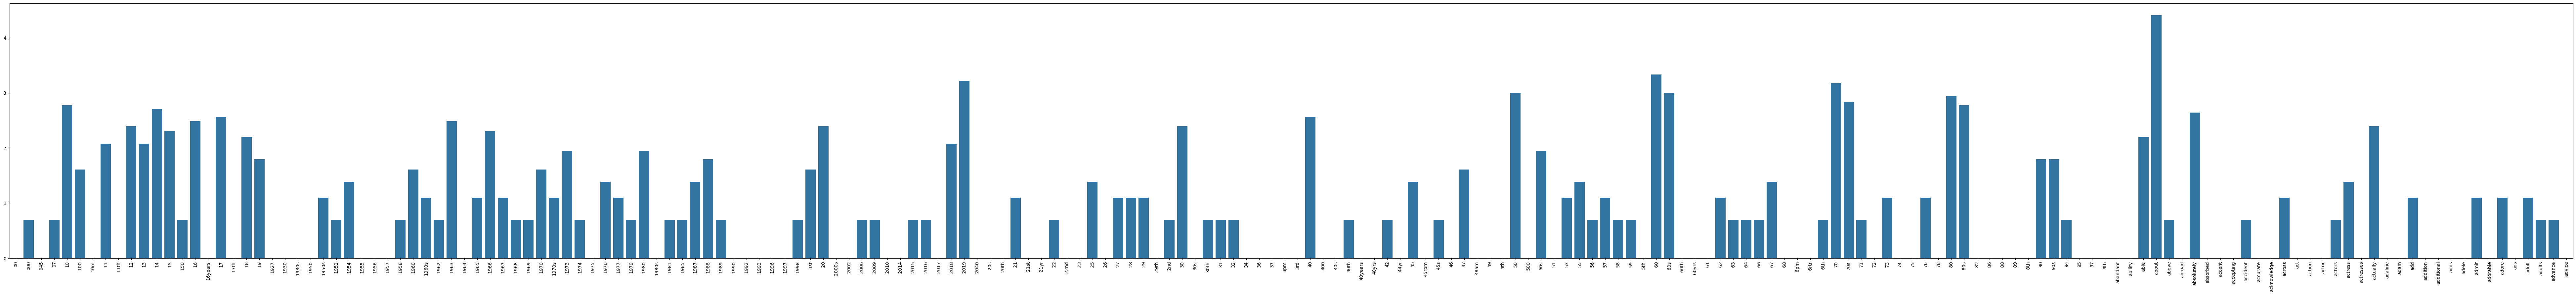

In [144]:
# do transformation via log
term_frequencies_log = [math.log(i) for i in term_frequencies]

plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:200],
                y=term_frequencies_log[:200])
g.set_xticklabels(count_vect.get_feature_names_out()[:200], rotation = 90)

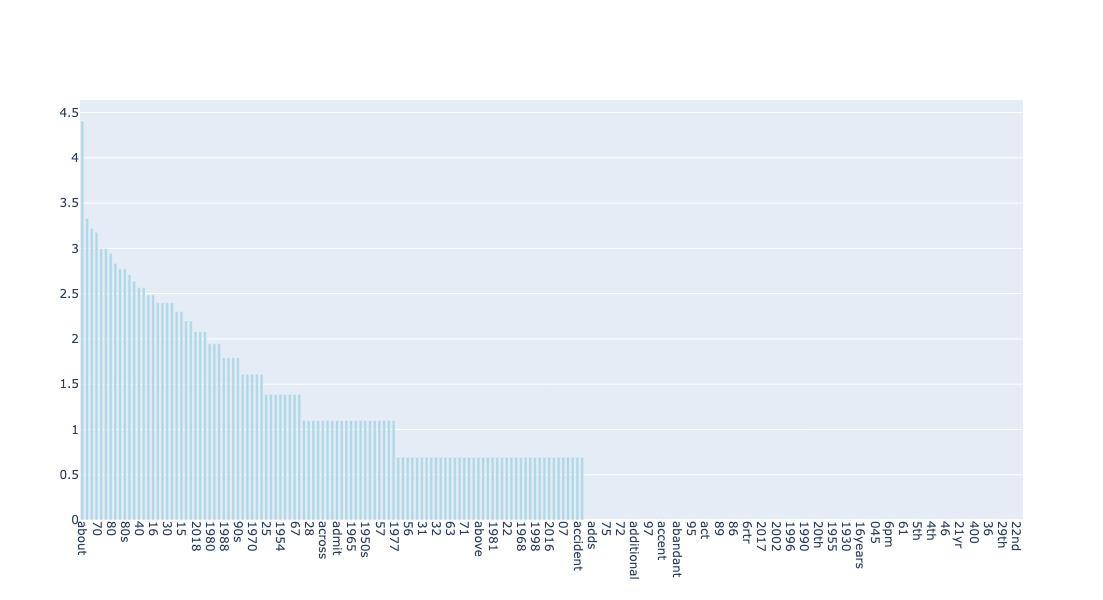

In [145]:
df = pd.DataFrame({
    'words': count_vect.get_feature_names_out()[:200],
    'frequencies': term_frequencies_log[:200]
})

df = df.sort_values('frequencies', ascending=False)

fig = go.Figure(data=[go.Bar(
    x=df['words'],
    y=df['frequencies'],
    hoverinfo='x+y',
    marker_color='lightblue'
)])

fig.update_layout(
    xaxis_tickangle=90,
    height=600,
    width=1200,
    bargap=0.4
)

fig.show()

### feature engineering

In [146]:
#Create separate DataFrames for each sentiment
# Get unique sentiment labels
sentiments = X['sentiment'].unique() 
# Dictionary to store DataFrames for each sentiment
sentiment_dfs = {}

for sentiment in sentiments:
    # Filter the original DataFrame by category
    sentiment_dfs[sentiment] = X[X['sentiment'] == sentiment].copy()

# Function to create term-document frequency DataFrame for each category
def create_term_document_df(df):
    count_vect = CountVectorizer()  # Initialize the CountVectorizer
    X_counts = count_vect.fit_transform(df['text'])  # Transform the text data into word counts
    
    # Get the unique words (vocabulary) from the vectorizer
    words = count_vect.get_feature_names_out()
    
    # Create a DataFrame where rows are documents and columns are words
    term_document_df = pd.DataFrame(X_counts.toarray(), columns=words)
    
    return term_document_df

# Create term-document frequency DataFrames for each category
term_document_dfs = {}  # Dictionary to store term-document DataFrames for each category

for sentiment in sentiments:
    term_document_dfs[sentiment] = create_term_document_df(sentiment_dfs[sentiment])


In [147]:
sentiment_number=0 #You can change it from 0 to 1
print(f"Filtered Term-Document Frequency DataFrame for Sentiment {sentiments[sentiment_number]}:")
term_document_dfs[sentiments[sentiment_number]]

Filtered Term-Document Frequency DataFrame for Sentiment not nostalgia:


,00,000,045,10,100,10m,11,12,14,15,...,youngest,youngsters,your,yourself,youth,youtube,yrs,yuo,zealand,zulus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


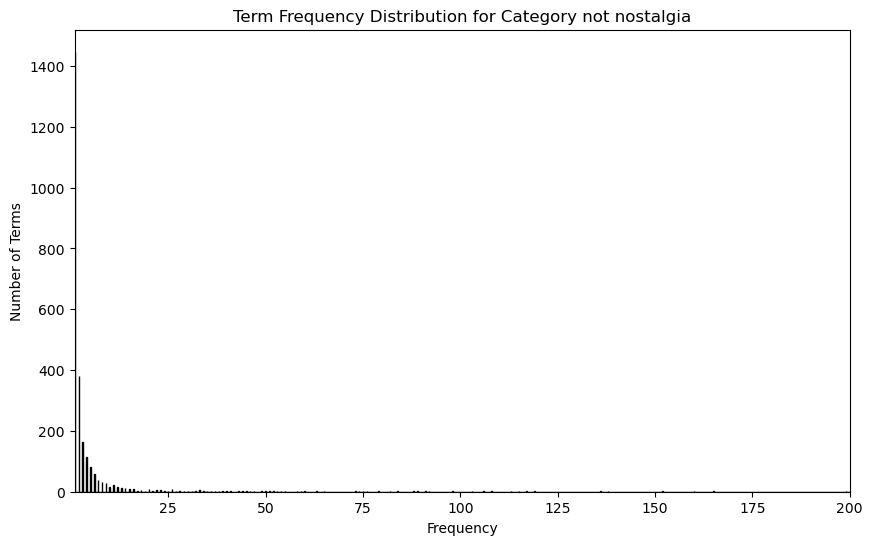

In [148]:
# Sum over all documents to get total frequency for each word
sentiment_number=0 #You can change it from 0 to 1
word_counts = term_document_dfs[sentiments[sentiment_number]].sum(axis=0).to_numpy()
 
# Visualize the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=5000, color='blue', edgecolor='black')
plt.title(f'Term Frequency Distribution for Category {sentiments[sentiment_number]}')
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.xlim(1, 200)
plt.show()

In [149]:
# this func is used to filter the word via frequency 
def filter_terms_by_percentage(sentiment_number, topOrbottom='top', percent=0.05):
    word_counts = term_document_dfs[sentiments[sentiment_number]].sum(axis=0).to_numpy()

    if topOrbottom == 'top':
        # if topOrbottom is top sort in descending order
        sorted_indices = np.argsort(word_counts)[::-1]  
    else:
        # else sort in ascending order
        sorted_indices = np.argsort(word_counts)  

    # Calculate the index corresponding to the specified percentage
    total_terms = len(word_counts)
    percent_index = int(percent * total_terms)

    # Get the indices of the specified percentage of terms
    filtered_indices = sorted_indices[:percent_index]

    # Filter terms based on index 
    filtered_words = [count_vect.get_feature_names_out()[i] for i in filtered_indices]
    
    print(f"Sentiment: {sentiments[sentiment_number]}\n")
    print(f"Number of terms in {topOrbottom} {int(percent * 100)}%: {percent_index}\n")
    print(f"Filtered terms: {filtered_words}\n")

    return None

In [150]:
filter_terms_by_percentage(0, 'top', 0.05)
print('-')
filter_terms_by_percentage(1, 'top', 0.05)
print('-')
filter_terms_by_percentage(0, 'bottom', 0.01)
print('-')
filter_terms_by_percentage(1, 'bottom', 0.01)

Sentiment: not nostalgia

Number of terms in top 5%: 130

Filtered terms: ['nearly', 'news', '94', 'not', 'headphones', 'match', 'faithful', 'fairground', 'everytime', 'pull', 'nearest', 'had', 'fry', 'gun', 'pity', 'decades', 'marin', 'eagle', 'hearts', 'focus', 'baritone', 'earnings', 'presented', 'doubt', '68', 'hearted', 'poor', 'hats', 'an', 'battle', 'ginnie', 'phoenix', 'featured', 'afford', 'announcement', 'matched', 'eh', 'nor', 'looks', 'predict', 'nerve', 'pops', 'depressing', 'embedded', 'afterwords', 'adam', '76', 'does', 'hardin', 'fifty', 'hd', 'happens', 'gucci', '27', 'posting', 'jensen', 'establishment', 'platform', 'greeted', 'appearances', 'contemporaries', 'barman', 'nc', 'never', 'problem', 'heaven', 'entertainer', 'chock', 'microphones', 'dylan', 'penny', 'neighborhood', '78', 'here', 'elvis', 'nelson', 'brilliantly', 'part', 'hears', 'ease', 'cherish', 'fore', '90', 'lyrics', 'drive', 'gen', 'either', 'moment', 'peaceful', 'nowadays', 'note', 'anybody', 'grew', 

In [151]:
# save dataframe as csv

# Loop through the dictionary of term-document DataFrames
for sentiment in term_document_dfs:
    
    # Create the DenseFormatDF object and convert to a transactional database
    obj = db.DenseFormatDF(term_document_dfs[sentiment])
    # the last two parameter is the threshold
    obj.convert2TransactionalDatabase(f'td_freq_db_{sentiment}.csv', '>=', 1)

Database size (total no of transactions) : 750
Number of items : 2295
Minimum Transaction Size : 3
Average Transaction Size : 21.644
Maximum Transaction Size : 70
Standard Deviation Transaction Size : 13.110095245013795
Variance in Transaction Sizes : 172.1040694259012
Sparsity : 0.9905690631808279


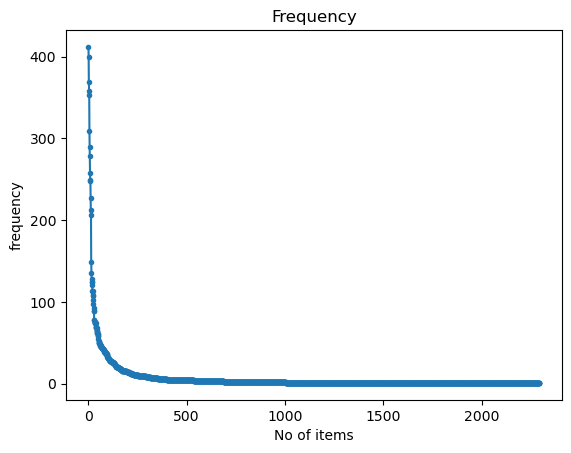

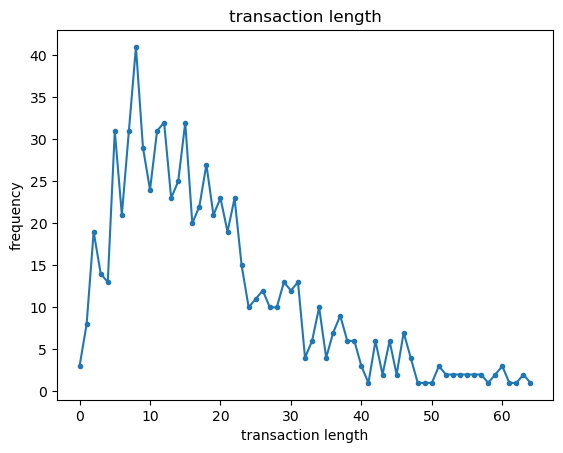

In [152]:
obj = tds.TransactionalDatabase('td_freq_db_nostalgia.csv')
obj.run()
obj.printStats()
# item Frequency Distribution describe an item appear in how many articles
obj.plotGraphs()

Database size (total no of transactions) : 749
Number of items : 2602
Minimum Transaction Size : 4
Average Transaction Size : 20.048064085447262
Maximum Transaction Size : 71
Standard Deviation Transaction Size : 10.368399001503127
Variance in Transaction Sizes : 107.64741937556671
Sparsity : 0.9922951329417958


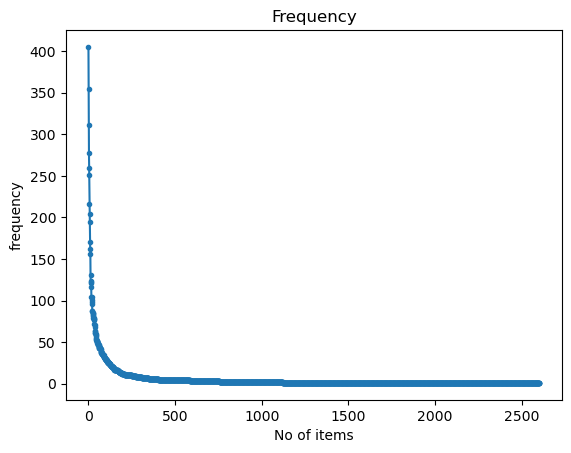

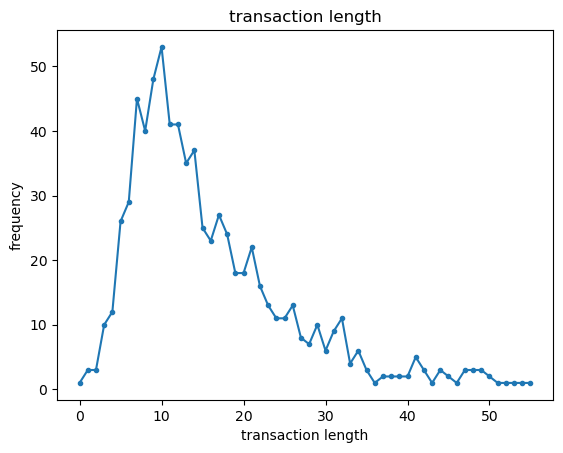

In [153]:
obj = tds.TransactionalDatabase('td_freq_db_not nostalgia.csv')
obj.run()
obj.printStats()
# item Frequency Distribution describe an item appear in how many articles
obj.plotGraphs()

In [154]:
minSup=11
# word combinations appear in at least 11 doc 
obj1 = alg.FPGrowth(iFile='td_freq_db_not nostalgia.csv', minSup=minSup)
obj1.mine()
frequentPatternsDF_not_nostalgia= obj1.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_not_nostalgia)))
print('Runtime: ' + str(obj1.getRuntime()))

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 5975
Runtime: 0.07557392120361328


In [155]:
#save the pattern
obj1.save('td_freq_db_not nostalgia.txt')
frequentPatternsDF_not_nostalgia

,Patterns,Support
0,generation,11
1,hit,11
2,which,11
3,enjoy,11
4,yes,11
...,...,...
5970,and this the,87
5971,and the,179
5972,this,354
5973,this the,184


In [156]:
minSup=11
# word combinations appear in at least 11 doc 
obj2 = alg.FPGrowth(iFile='td_freq_db_nostalgia.csv', minSup=minSup)
obj2.mine()
frequentPatternsDF_nostalgia= obj2.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_nostalgia)))

print('Runtime: ' + str(obj2.getRuntime()))

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 41581
Runtime: 0.5894582271575928


In [157]:
#save the patterns
obj2.save('td_freq_db_nostalgia.txt')
frequentPatternsDF_nostalgia

,Patterns,Support
0,before,11
1,words,11
2,tune,11
3,born,11
4,house,11
...,...,...
41576,the my this,123
41577,the this,212
41578,my,400
41579,my this,252


In [158]:
dfs = [frequentPatternsDF_not_nostalgia, frequentPatternsDF_nostalgia]


# Identify patterns that appear in more than one category
# Count how many times each pattern appears across all dataframes
pattern_counts = {}
for df in dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

# Filter out patterns that appear in more than one dataframe
unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
# Calculate the total number of patterns across all categories
total_patterns_count = sum(len(df) for df in dfs)
# Calculate how many patterns were discarded
discarded_patterns_count = total_patterns_count - len(unique_patterns)

# For each category, filter the patterns to keep only the unique ones
filtered_dfs = []
for df in dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

# Merge the filtered dataframes into a final dataframe
final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)

# Sort by support
final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

# Display the final result
print(final_pattern_df)
# Print the number of discarded patterns
print(f"Number of patterns discarded: {discarded_patterns_count}")

                     Patterns  Support
42847                   to my      227
40832                memories      227
42851                the this      212
42842                 song my      212
42849                  the my      192
...                       ...      ...
30525    love back in and the       11
11646  had in this was to the       11
30529         love back me my       11
30531      love back and song       11
0                  generation       11

[42852 rows x 2 columns]
Number of patterns discarded: 4704


In [159]:
# convert 'text' column into term-document matrix using CountVectorizer
count_vect = CountVectorizer()
# do fit_transform
X_tdm = count_vect.fit_transform(X['text'])
# extracts these terms and returns a list of vocabulary
terms = count_vect.get_feature_names_out()

# tokenize the sentences into sets of unique words
X['tokenized_text'] = X['text'].str.split().apply(set)

# initialize the pattern matrix
pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pattern_df['Patterns'])

# iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split())  # Tokenize pattern into words
    pattern_matrix[pattern] = X['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

# convert the term-document matrix to a DataFrame
tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=X.index)

# Concatenate the original tdm and the pattern matrix to augment the features
augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)

augmented_df

,00,000,045,07,10,100,10m,11,11th,12,...,love when was and the this,had of and was the,had of and my the,love back in song,love back in and,love back in and the,had in this was to the,love back me my,love back and song,generation
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dimension Reduction

In [160]:
# dimensionality reduction

X_pca_tdm = PCA(n_components=2).fit_transform(tdm_df.values)
X_tsne_tdm = TSNE(n_components=2).fit_transform(tdm_df.values)
X_umap_tdm = umap.UMAP(n_components=2).fit_transform(tdm_df.values)

In [161]:
print("PCA 降為兩維 shape 是:", X_pca_tdm.shape)
print("TSNE 降為兩維 shape 是:", X_pca_tdm.shape)
print("UMAP 降為兩維 shape 是:", X_pca_tdm.shape)

PCA 降為兩維 shape 是: (1499, 2)
TSNE 降為兩維 shape 是: (1499, 2)
UMAP 降為兩維 shape 是: (1499, 2)


In [162]:
ratio_dict = {}

for dim in [2, 3, 4, 5, 6]:
    pca = PCA(n_components=dim)
    # do fit transform
    pca.fit(tdm_df.values) 
    X_pca_tdm = pca.transform(tdm_df.values)
    # calculate explained_variance_ratio
    explained_variance_pca = np.sum(pca.explained_variance_ratio_)

    X_umap_tdm = umap.UMAP(n_components=dim).fit_transform(tdm_df.values)
    
    def variance_retained(original_data, transformed_data):
        original_variance = np.var(original_data, axis=0).sum()
        transformed_variance = np.var(transformed_data, axis=0).sum()
        return transformed_variance / original_variance
    
    variance_retained_pca = variance_retained(tdm_df.values, X_pca_tdm)
    variance_retained_umap = variance_retained(tdm_df.values, X_umap_tdm)
    
    print(f"PCA explained variance ratio when dimension is {dim}: {explained_variance_pca:.4f}")
    print(f"UMAP variance retained when dimension is {dim}: {variance_retained_umap:.4f}")

    ratio_dict[dim] = [round(explained_variance_pca, 4), round(variance_retained_umap, 4)]

PCA explained variance ratio when dimension is 2: 0.1268
UMAP variance retained when dimension is 2: 0.1272
PCA explained variance ratio when dimension is 3: 0.1572
UMAP variance retained when dimension is 3: 0.0909
PCA explained variance ratio when dimension is 4: 0.1813
UMAP variance retained when dimension is 4: 0.0786
PCA explained variance ratio when dimension is 5: 0.2041
UMAP variance retained when dimension is 5: 0.0733
PCA explained variance ratio when dimension is 6: 0.2265
UMAP variance retained when dimension is 6: 0.0709


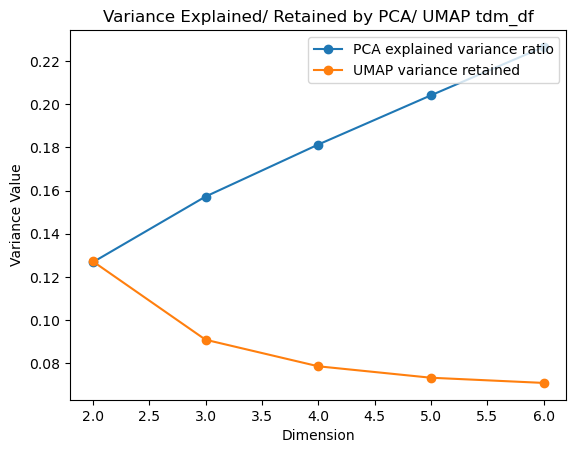

In [163]:
df = pd.DataFrame.from_dict(ratio_dict, orient='index')

# set column names
df.columns = ['PCA explained variance ratio', 'UMAP variance retained']

fig, ax = plt.subplots()

df.plot(kind='line', ax=ax, marker='o')

# set title and axes title
ax.set_title('Variance Explained/ Retained by PCA/ UMAP tdm_df')
ax.set_xlabel('Dimension')
ax.set_ylabel('Variance Value')

# put legend on the upper right
ax.legend(loc='upper right')

# show plt
plt.show()

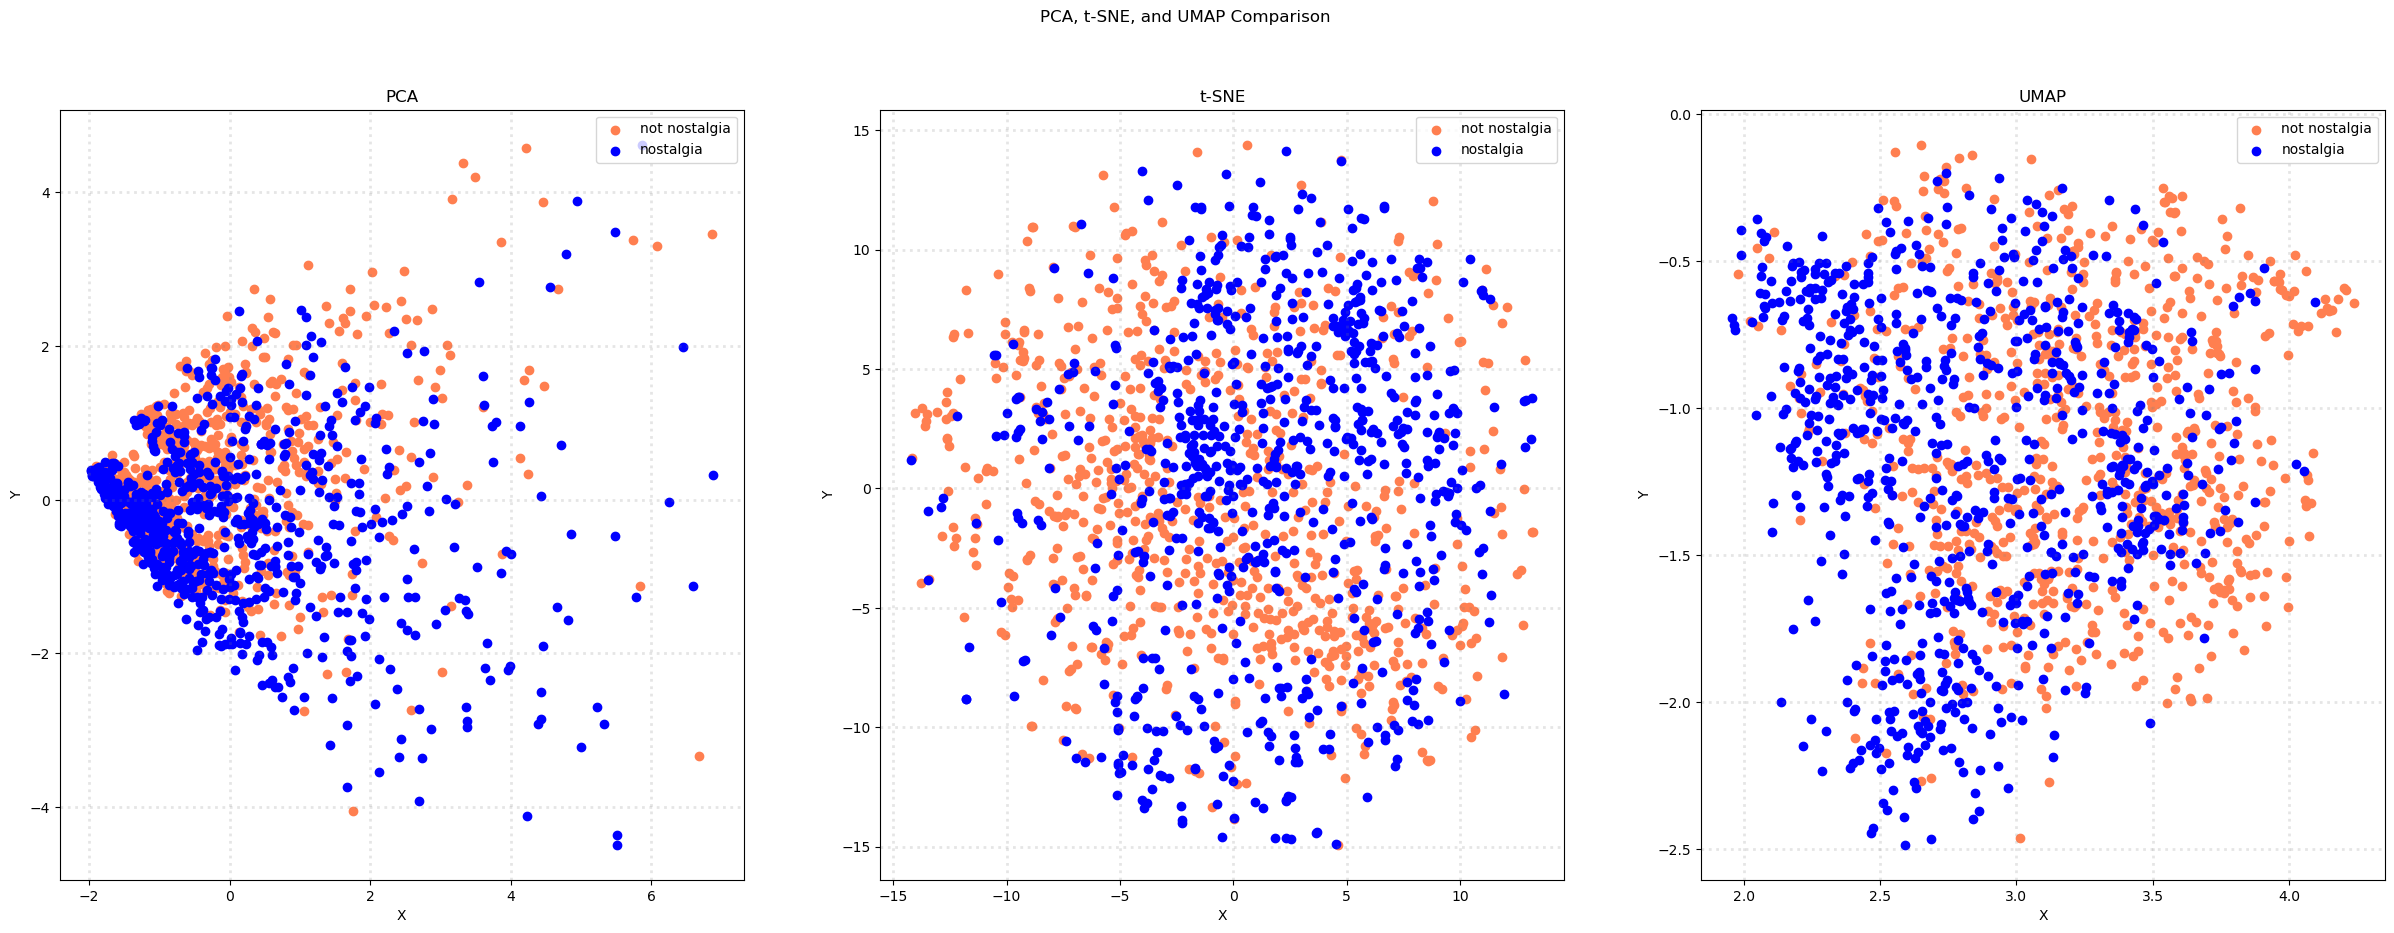

In [164]:
# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = X['sentiment'].unique() 

# Create 3 subplots for PCA, t-SNE, and UMAP
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['sentiment'] == category].T[0]
        ys = X_reduced[X['sentiment'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')

# Step 4: Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], X_pca_tdm, 'PCA')
plot_scatter(axes[1], X_tsne_tdm, 't-SNE')
plot_scatter(axes[2], X_umap_tdm, 'UMAP')

plt.show()

In [165]:
#This might take a couple of minutes to execute
#Applying dimensionality reduction with both the document-term frequency data and the pattern derived data
# Apply PCA, t-SNE, and UMAP to the data
X_pca_aug = PCA(n_components=2).fit_transform(augmented_df.values)
X_tsne_aug = TSNE(n_components=2).fit_transform(augmented_df.values)
X_umap_aug = umap.UMAP(n_components=2).fit_transform(augmented_df.values)

In [166]:
# 執行 PCA 降維

ratio_dict_aug = {}

for dim in [2, 3, 4, 5, 6]:
    pca = PCA(n_components=dim)
    pca.fit(augmented_df.values)  # 先擬合
    X_pca_aug = pca.transform(augmented_df.values)  # 再轉換數據
    explained_variance_pca = np.sum(pca.explained_variance_ratio_)  # 計算解釋方差

    X_umap_aug = umap.UMAP(n_components=dim).fit_transform(augmented_df.values)
    
    # 計算降維前後的方差保留值
    def variance_retained(original_data, transformed_data):
        original_variance = np.var(original_data, axis=0).sum()
        transformed_variance = np.var(transformed_data, axis=0).sum()
        return transformed_variance / original_variance
    
    variance_retained_pca = variance_retained(augmented_df.values, X_pca_aug)
    variance_retained_umap = variance_retained(augmented_df.values, X_umap_aug)
    
    
    # 輸出結果
    print(f"PCA explained variance ratio when dimension is {dim}: {explained_variance_pca:.4f}")
    print(f"UMAP variance retained when dimension is {dim}: {variance_retained_umap:.4f}")

    ratio_dict[dim] = [round(explained_variance_pca, 4), round(variance_retained_umap, 4)]

PCA explained variance ratio when dimension is 2: 0.1494
UMAP variance retained when dimension is 2: 0.0070
PCA explained variance ratio when dimension is 3: 0.1736
UMAP variance retained when dimension is 3: 0.0050
PCA explained variance ratio when dimension is 4: 0.1954
UMAP variance retained when dimension is 4: 0.0044
PCA explained variance ratio when dimension is 5: 0.2155
UMAP variance retained when dimension is 5: 0.0042
PCA explained variance ratio when dimension is 6: 0.2336
UMAP variance retained when dimension is 6: 0.0040


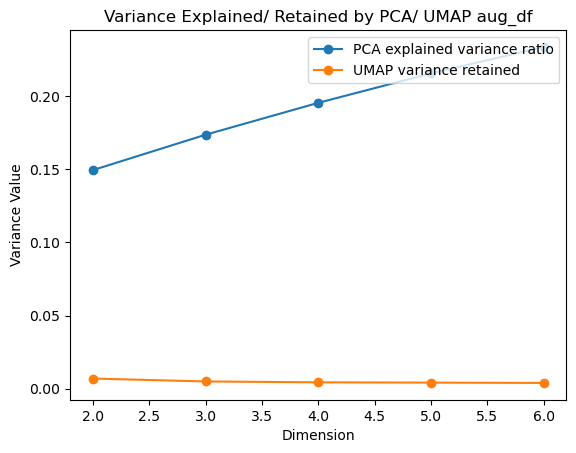

In [167]:
df = pd.DataFrame.from_dict(ratio_dict, orient='index')

# 設置 columns 的名稱
df.columns = ['PCA explained variance ratio', 'UMAP variance retained']

# 創建圖形
fig, ax = plt.subplots()

# 畫出兩條折線圖
df.plot(kind='line', ax=ax, marker='o')

# 設置標題和軸標籤
ax.set_title('Variance Explained/ Retained by PCA/ UMAP aug_df')
ax.set_xlabel('Dimension')
ax.set_ylabel('Variance Value')

# 將圖例放置在右上角
ax.legend(loc='upper right')

# 顯示圖表
plt.show()

### Summary：
##### From the chart above, it can be observed that the PCA explained variance ratio increases as the dimensionality increases, while UMAP shows the opposite trend. Additionally, the PCA explained variance ratio remains relatively low across all dimensions.

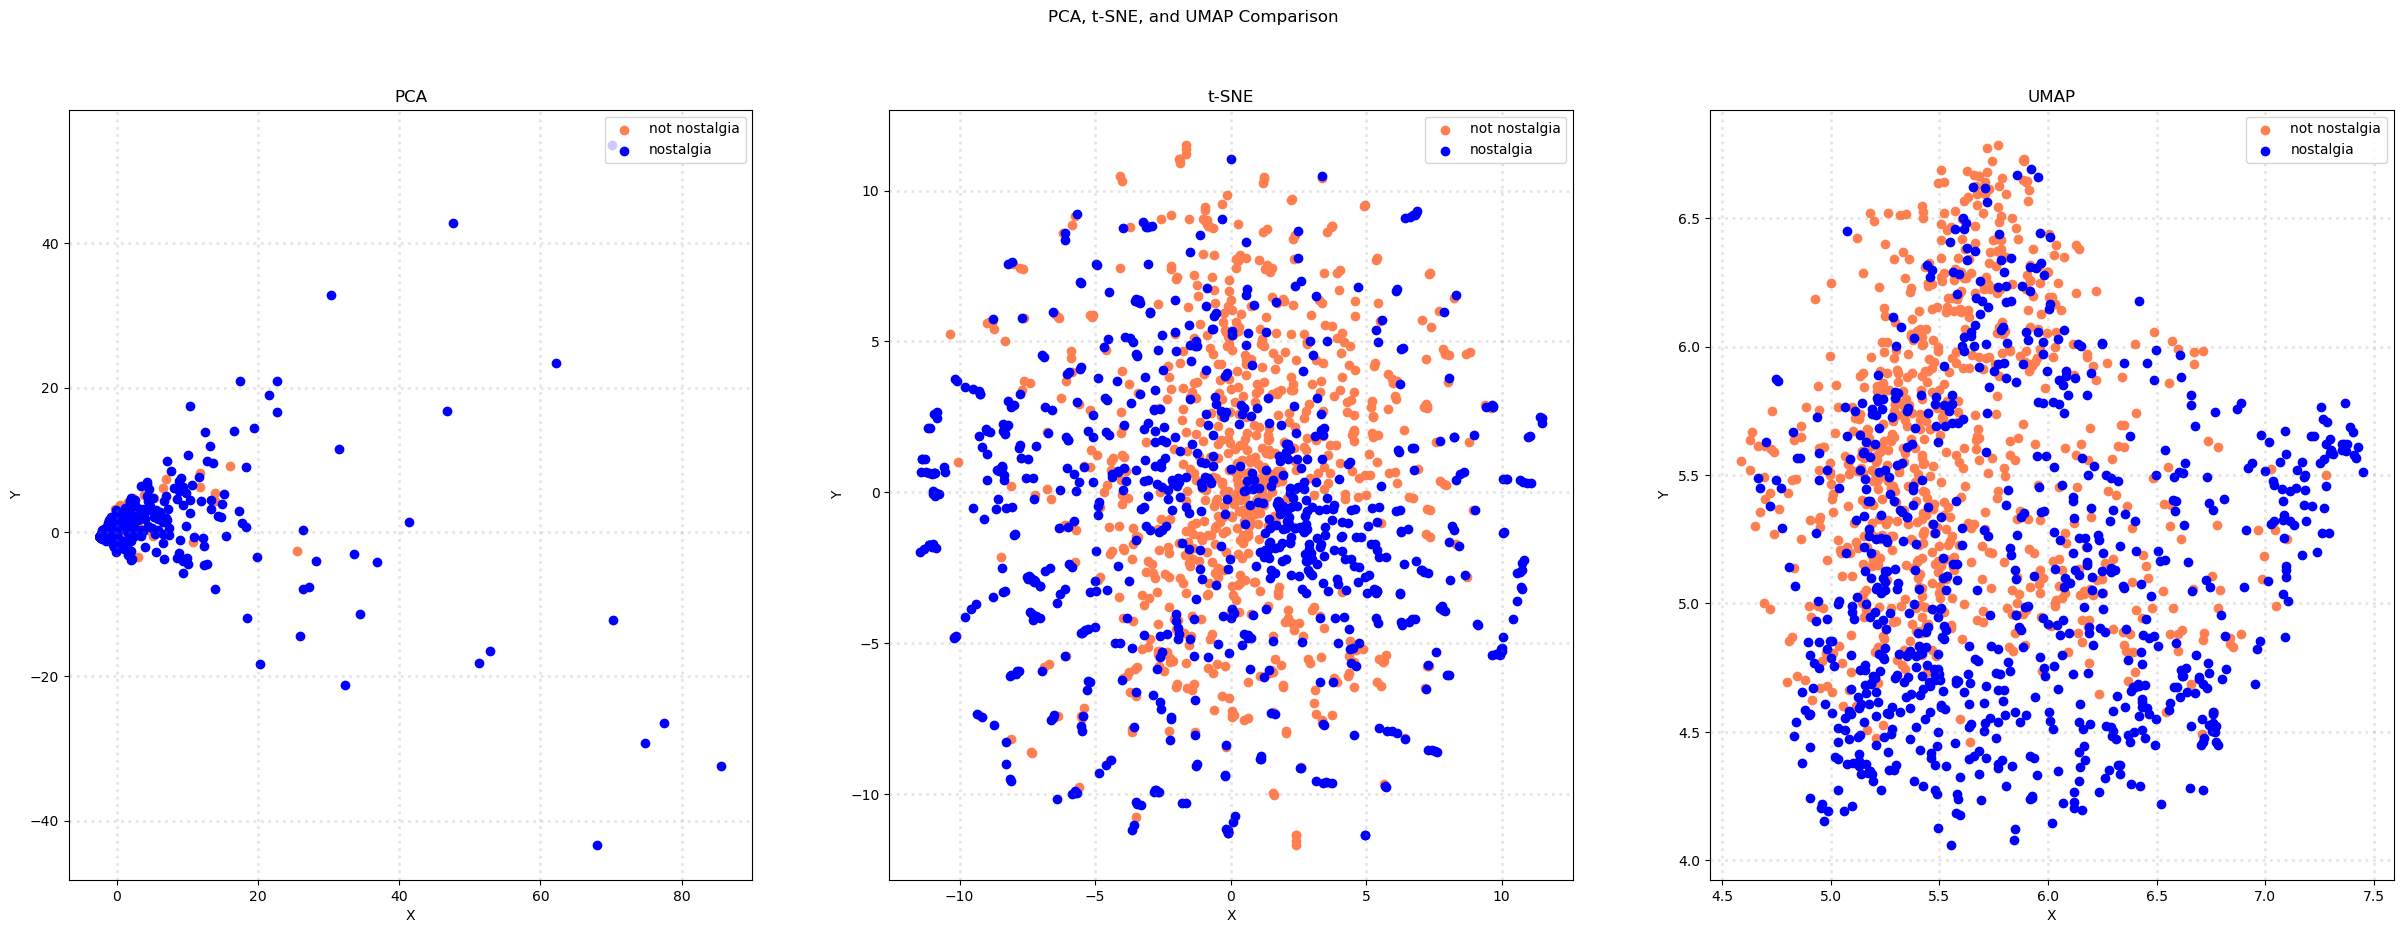

In [168]:
# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = X['sentiment'].unique() 

fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['sentiment'] == category].T[0]
        ys = X_reduced[X['sentiment'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')

# Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], X_pca_aug, 'PCA')
plot_scatter(axes[1], X_tsne_aug, 't-SNE')
plot_scatter(axes[2], X_umap_aug, 'UMAP')

plt.show()

In [169]:
# Answer here
X_pca_aug_3 = PCA(n_components=3).fit_transform(augmented_df.values)
X_tsne_aug_3 = TSNE(n_components=3).fit_transform(augmented_df.values)
X_umap_aug_3 = umap.UMAP(n_components=3).fit_transform(augmented_df.values)

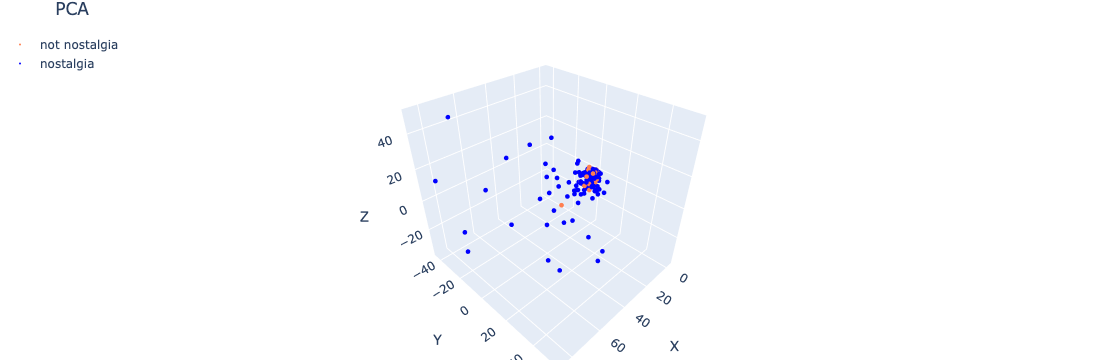

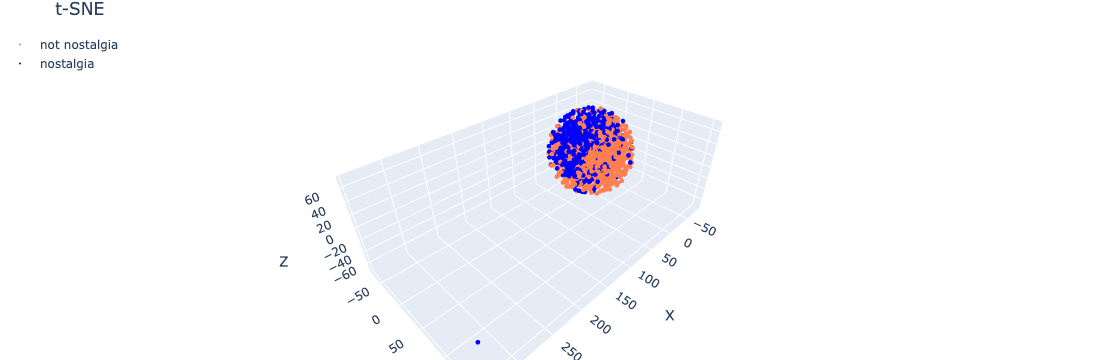

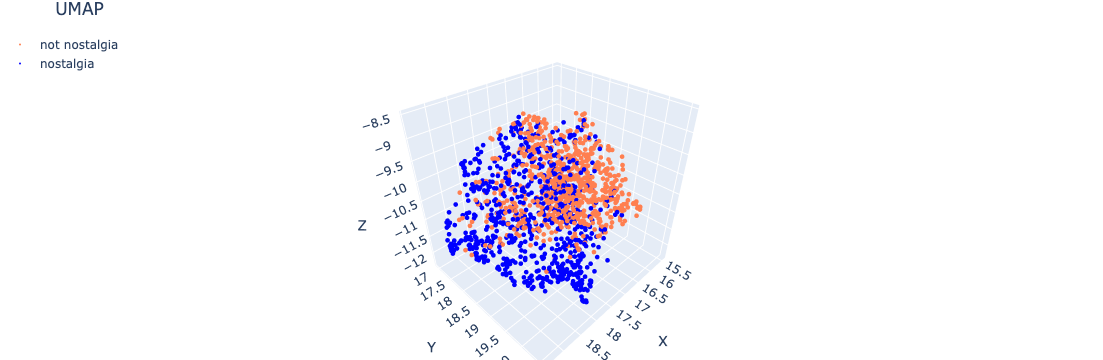

In [170]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_scatter_3d(X_reduced, title):
    fig = go.Figure()

    for c, category in zip(col, categories):
        xs = X_reduced[X['sentiment'] == category][:, 0]
        ys = X_reduced[X['sentiment'] == category][:, 1]
        zs = X_reduced[X['sentiment'] == category][:, 2]

        fig.add_trace(go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode='markers',
            marker=dict(size=1.5, color=c),
            name=category
        ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        legend=dict(x=0, y=1.0),
        margin=dict(l=0, r=0, b=0, t=30)
    )
    
    return fig

fig_pca = plot_scatter_3d(X_pca_aug_3, 'PCA')
fig_tsne = plot_scatter_3d(X_tsne_aug_3, 't-SNE')
fig_umap = plot_scatter_3d(X_umap_aug_3, 'UMAP')

fig_pca.show()
fig_tsne.show()
fig_umap.show()


### Prepare For Training

In [171]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(X.sentiment)

LabelBinarizer()

In [172]:
# do onehot encoding
X['sentiment_onehot'] = mlb.transform(X['sentiment']).tolist()
X[0:9]

,sentiment,text,unigrams,lemmatized_text,tokenized_text,sentiment_onehot
0,not nostalgia,He was a singer with a golden voice that I lov...,"[He, was, a, singer, with, a, golden, voice, t...",singer golden voice love hear time . great fan...,"{have, age, feel, Lord, in, at, emotional, tho...",[1]
1,nostalgia,The mist beautiful voice ever I listened to hi...,"[The, mist, beautiful, voice, ever, I, listene...",mist beautiful voice ever listened kid still l...,"{listened, beautiful, an, ever, still, love, a...",[0]
2,nostalgia,I have most of Mr. Reeves songs. Always love ...,"[I, have, most, of, Mr., Reeves, songs, ., Alw...","Mr. Reeves song . Always love smooth voice , c...","{have, town, age, find, Mr., sounds, pretensio...",[0]
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...,"[30, day, leave, from, 1st, tour, in, Viet, Na...",30 day leave 1st tour Viet Nam convince Mary L...,"{pray, have, reality., back, hope, came, man, ...",[1]
4,nostalgia,listening to his songs reminds me of my mum wh...,"[listening, to, his, songs, reminds, me, of, m...",listening song reminds mum played everyday,"{me, listening, of, my, mum, to, who, everyday...",[0]
5,nostalgia,"Every time I heard this song as a child, I use...","[Every, time, I, heard, this, song, as, a, chi...","Every time heard song child , used cry .... re...","{used, your, it, over, still, this, RIP, a, of...",[0]
6,nostalgia,"My dad loved listening to Jim Reeves, when I w...","[My, dad, loved, listening, to, Jim, Reeves, ,...","dad loved listening Jim Reeves , teenager back...","{teenager, didn't, loved, My, back, in, 70's, ...",[0]
7,nostalgia,i HAVE ALSO LISTENED TO Jim Reeves since child...,"[i, HAVE, ALSO, LISTENED, TO, Jim, Reeves, sin...",ALSO LISTENED Jim Reeves since childhood 71 no...,"{music., feeling, ., in, Reeves, love, a, he, ...",[0]
8,not nostalgia,Wherever you are you always in my heart,"[Wherever, you, are, you, always, in, my, heart]",Wherever always heart,"{you, Wherever, always, are, in, my, heart}",[1]


In [173]:
# We retrieve 3 sentences for a random record
document_to_transform_1 = []
random_record_1 = X.iloc[50]
random_record_1 = random_record_1['text']
document_to_transform_1.append(random_record_1)

document_to_transform_2 = []
random_record_2 = X.iloc[100]
random_record_2 = random_record_2['text']
document_to_transform_2.append(random_record_2)

document_to_transform_3 = []
random_record_3 = X.iloc[150]
random_record_3 = random_record_3['text']
document_to_transform_3.append(random_record_3)

In [174]:
# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# print vectors
print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [175]:
# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print 
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.032174
Cosine Similarity using count bw 1 and 3: 0.027864
Cosine Similarity using count bw 2 and 3: 0.000000
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000


In [176]:
# extract integer of each label
X["sentiment_onehot_int"] = X["sentiment_onehot"].apply(lambda x: str(x[0]))

### training

In [177]:
# Create a mapping from numerical labels to category names
sentiment_mapping = dict(X[['sentiment', "sentiment_onehot_int"]].drop_duplicates().values)

# Convert the numerical category labels to text labels
target_names = [sentiment_mapping[label] for label in sorted(sentiment_mapping.keys())]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, X['sentiment'], test_size=0.3, random_state=42)

In [178]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.8688888888888889

Classification Report:
               precision    recall  f1-score   support

           0     0.8222    0.9528    0.8827       233
           1     0.9389    0.7788    0.8514       217

    accuracy                         0.8689       450
   macro avg     0.8806    0.8658    0.8670       450
weighted avg     0.8785    0.8689    0.8676       450



In [179]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(augmented_df, X['sentiment'], test_size=0.3, random_state=42)

In [180]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.8244444444444444

Classification Report:
               precision    recall  f1-score   support

           0     0.9529    0.6953    0.8040       233
           1     0.7464    0.9631    0.8410       217

    accuracy                         0.8244       450
   macro avg     0.8497    0.8292    0.8225       450
weighted avg     0.8534    0.8244    0.8218       450



### 透過 for loop 來 search 最適當的 minSup

In [181]:
def searchForMinsup(minSup=11) -> list:
    print("minSup: ", minSup)
    obj1 = alg.FPGrowth(iFile='td_freq_db_not nostalgia.csv', minSup=minSup)# 至少在九個文檔中出現的詞語組合 
    obj1.mine()
    frequentPatternsDF_not_nostalgia= obj1.getPatternsAsDataFrame()
    print('Total No of patterns: ' + str(len(frequentPatternsDF_not_nostalgia))) #print the total number of patterns
    print('Runtime: ' + str(obj1.getRuntime())) #measure the runtime
    
    obj1.save('td_freq_db_not nostalgia_' + str(minSup) + '.txt') #save the patterns
    
    
    
    obj2 = alg.FPGrowth(iFile='td_freq_db_nostalgia.csv', minSup=minSup)# 至少在九個文檔中出現的詞語組合 
    obj2.mine()
    frequentPatternsDF_nostalgia= obj2.getPatternsAsDataFrame()
    print('Total No of patterns: ' + str(len(frequentPatternsDF_nostalgia))) #print the 
    print('Runtime: ' + str(obj2.getRuntime())) #measure the runtime
    
    obj2.save('td_freq_db_nostalgia_' + str(minSup) + '.txt') #save the patterns
    frequentPatternsDF_nostalgia
    
    
    
    
    dfs = [frequentPatternsDF_not_nostalgia, frequentPatternsDF_nostalgia]
    
    
    # Identify patterns that appear in more than one category
    # Count how many times each pattern appears across all dataframes
    pattern_counts = {}
    for df in dfs:
        for pattern in df['Patterns']:
            if pattern not in pattern_counts:
                pattern_counts[pattern] = 1
            else:
                pattern_counts[pattern] += 1
    
    # Filter out patterns that appear in more than one dataframe
    unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
    # Calculate the total number of patterns across all categories
    total_patterns_count = sum(len(df) for df in dfs)
    # Calculate how many patterns were discarded
    discarded_patterns_count = total_patterns_count - len(unique_patterns)
    
    # For each category, filter the patterns to keep only the unique ones
    filtered_dfs = []
    for df in dfs:
        filtered_df = df[df['Patterns'].isin(unique_patterns)]
        filtered_dfs.append(filtered_df)
    
    # Merge the filtered dataframes into a final dataframe
    final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)
    
    # Sort by support
    final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)
    
    # Print the number of discarded patterns
    print(f"Number of patterns discarded when {minSup} is: {discarded_patterns_count}")
    
    
    # Convert 'text' column into term-document matrix using CountVectorizer
    count_vect = CountVectorizer()
    X_tdm = count_vect.fit_transform(X['text'])  # X['text'] contains your text data
    terms = count_vect.get_feature_names_out()  # Original terms in the vocabulary
    
    # Tokenize the sentences into sets of unique words
    X['tokenized_text'] = X['text'].str.split().apply(set)
    
    # Initialize the pattern matrix
    pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pattern_df['Patterns'])
    
    # Iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
    for pattern in final_pattern_df['Patterns']:
        pattern_words = set(pattern.split())  # Tokenize pattern into words
        pattern_matrix[pattern] = X['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)
    
    # Convert the term-document matrix to a DataFrame for easy merging
    tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=X.index)
    
    # Concatenate the original TDM and the pattern matrix to augment the features
    augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)
    
    
    
    
    # Create a mapping from numerical labels to category names
    sentiment_mapping = dict(X[['sentiment', "sentiment_onehot_int"]].drop_duplicates().values)
    
    # Convert the numerical category labels to text labels
    target_names = [sentiment_mapping[label] for label in sorted(sentiment_mapping.keys())]
    
    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(augmented_df, X['sentiment'], test_size=0.3, random_state=42)
    
    # Train the Naive Bayes classifier
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = nb_classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))
    
    return [accuracy, precision, recall]
    

In [182]:
dict_minSup = {}
for x in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]:
    result = searchForMinsup(minSup = x)
    dict_minSup[x] = result

minSup:  10
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 7546
Runtime: 0.12644481658935547
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 53761
Runtime: 0.38252997398376465
Number of patterns discarded when 10 is: 5636

Classification Report:
               precision    recall  f1-score   support

           0     0.9464    0.6824    0.7930       233
           1     0.7376    0.9585    0.8337       217

    accuracy                         0.8156       450
   macro avg     0.8420    0.8205    0.8133       450
weighted avg     0.8457    0.8156    0.8126       450

minSup:  20
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 1493
Runtime: 0.037400007247924805
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 8696
Runtime: 0.11971783638000488
Number of patter

In [183]:
df = pd.DataFrame.from_dict(dict_minSup, orient='index', columns = ["accuracy", "precision", "recall"])

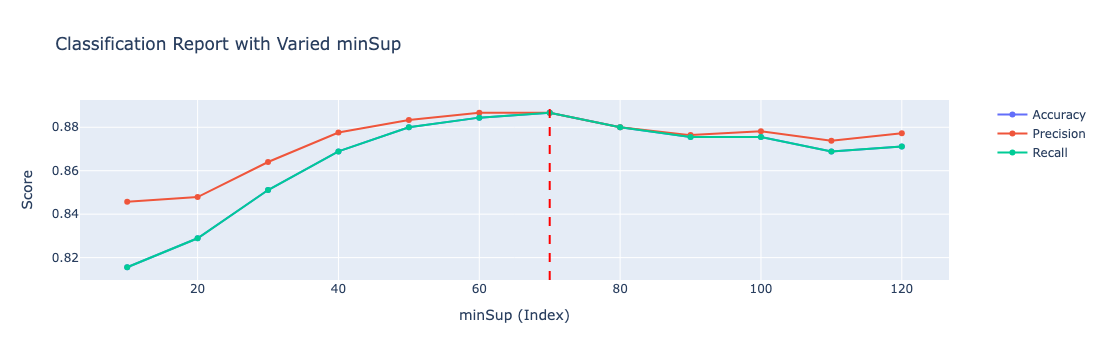

In [184]:
# Create an interactive line chart using Plotly
fig = go.Figure()

# Add lines for accuracy, precision, and recall
fig.add_trace(go.Scatter(x=df.index, y=df['accuracy'], mode='lines+markers', name='Accuracy'))
fig.add_trace(go.Scatter(x=df.index, y=df['precision'], mode='lines+markers', name='Precision'))
fig.add_trace(go.Scatter(x=df.index, y=df['recall'], mode='lines+markers', name='Recall'))

# Add a vertical dashed line at index = 70
fig.add_shape(type='line',
              x0=70, y0=0, x1=70, y1=1, 
              line=dict(color='Red', width=2, dash='dash'),
              xref='x', yref='paper')

# Customize layout
fig.update_layout(
    title='Classification Report with Varied minSup',
    xaxis_title='minSup (Index)',
    yaxis_title='Score',
    legend=dict(x=1.05, y=1),
    showlegend=True
)

# Show the interactive plot
fig.show()

### Use TF-IDF to predict

In [185]:
# start to use TF-IDF

texts = X['text']  # 假設資料集中有一個 'text' 列包含 YouTube 評論

# 初始化 TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# 將文本轉換為 TF-IDF 特徵矩陣
X_tfidf = tfidf_vectorizer.fit_transform(texts)

# 轉換為 DataFrame，方便查看
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [186]:
tfidf_df

,00,000,045,07,10,100,10m,11,11th,12,...,yours,yourself,youth,youthful,youtube,yrs,yuo,yup,zealand,zulus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
"""
建立 tf-idf 矩陣完成後
要來選擇需要使用的 Navie Bayes 分類器
1. Multinomial based：
在 Lab1-Master 中使用的是 Multinomial based，這種分類器適合「詞頻」的 vector
2. Bernoulli based：
主要用於二元特徵，即特徵只能取 0 或 1 的情況，例如 0 代表沒有出現，1 代表有出現
3. Gaussian based：
適合用來處理連續資料

在此我認為 TF-IDF 資料比較適合使用 Gaussian based 來做預測，但我會嘗試不同的分類器並且混合不同的資料，包括 單純的 TF-IDF vecotr 以及 TF-IDF vector 和 pattern matrix
"""

# 使用 tfidf 搭配 Gaussian based
from sklearn.naive_bayes import GaussianNB

# 將 tfidf_df 和 y 分成訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, X["sentiment"], test_size=0.2, random_state=42)

# 建立並訓練 Gaussian Naive Bayes 模型
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = gnb_classifier.predict(X_test)

# 評估結果
print("GaussianNB Classifier Results (TF-IDF):")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

GaussianNB Classifier Results (TF-IDF):
Accuracy: 0.6733333333333333
               precision    recall  f1-score   support

    nostalgia       0.65      0.80      0.72       158
not nostalgia       0.71      0.53      0.60       142

     accuracy                           0.67       300
    macro avg       0.68      0.67      0.66       300
 weighted avg       0.68      0.67      0.67       300



In [188]:
# 使用 tfidf 搭配 Multinomial based

# 建立並訓練 MultinomialNB Naive Bayes 模型
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = nb_classifier.predict(X_test)

# 評估結果
print("MultinomialNB Classifier Results (TF-IDF):")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

MultinomialNB Classifier Results (TF-IDF):
Accuracy: 0.8466666666666667
               precision    recall  f1-score   support

    nostalgia       0.81      0.93      0.86       158
not nostalgia       0.91      0.75      0.82       142

     accuracy                           0.85       300
    macro avg       0.86      0.84      0.84       300
 weighted avg       0.85      0.85      0.85       300



## 加入停用詞

In [189]:
# 假設資料集中有一個 'text' 列包含 YouTube 評論
texts = X['text']  

# 初始化 TfidfVectorizer 並移除英文停用詞
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# 將文本轉換為 TF-IDF 特徵矩陣
X_tfidf = tfidf_vectorizer.fit_transform(texts)

# 轉換為 DataFrame，方便查看
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# 顯示結果
print(len(tfidf_df.columns))

3485


In [190]:
# 使用加入停用字的 tf-idf vector 搭配 Gaussian based
# 將 tfidf_df 和 y 分成訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, X["sentiment"], test_size=0.4, random_state=42)

# 建立並訓練 Gaussian Naive Bayes 模型
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = gnb_classifier.predict(X_test)

# 評估結果
print("GaussianNB Classifier Results (TF-IDF with stop words):")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

GaussianNB Classifier Results (TF-IDF with stop words):
Accuracy: 0.64
               precision    recall  f1-score   support

    nostalgia       0.62      0.79      0.69       309
not nostalgia       0.68      0.48      0.56       291

     accuracy                           0.64       600
    macro avg       0.65      0.64      0.63       600
 weighted avg       0.65      0.64      0.63       600



In [191]:
# 使用加入停用字的 tf-idf vector 搭配 Multinomial based
# 建立並訓練 MultinomialNB Naive Bayes 模型
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = nb_classifier.predict(X_test)

# 評估結果
print("MultinomialNB Classifier Results (TF-IDF with stop words):")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

MultinomialNB Classifier Results (TF-IDF with stop words):
Accuracy: 0.8466666666666667
               precision    recall  f1-score   support

    nostalgia       0.79      0.95      0.87       309
not nostalgia       0.94      0.73      0.82       291

     accuracy                           0.85       600
    macro avg       0.86      0.84      0.84       600
 weighted avg       0.86      0.85      0.84       600



In [192]:
# 使用 tf-idf 結合 pattern matrix 搭配 Gaussian based
augmented_df = pd.concat([tfidf_df, pattern_matrix], axis=1)

# 將 tfidf_df 和 y 分成訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(augmented_df, X["sentiment"], test_size=0.4, random_state=42)

# 建立並訓練 Gaussian Naive Bayes 模型
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = gnb_classifier.predict(X_test)

# 評估結果
print("GaussianNB Classifier Results (augmented):")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

GaussianNB Classifier Results (augmented):
Accuracy: 0.7316666666666667
               precision    recall  f1-score   support

    nostalgia       0.66      0.97      0.79       309
not nostalgia       0.93      0.48      0.63       291

     accuracy                           0.73       600
    macro avg       0.80      0.72      0.71       600
 weighted avg       0.79      0.73      0.71       600



In [193]:
# 使用 tf-idf 結合 pattern matrix 搭配 Multinomial based

# 建立並訓練 MultinomialNB Naive Bayes 模型
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = nb_classifier.predict(X_test)

# 評估結果
print("MultinomialNB Classifier Results (TF-IDF with stop words):")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

MultinomialNB Classifier Results (TF-IDF with stop words):
Accuracy: 0.8416666666666667
               precision    recall  f1-score   support

    nostalgia       0.93      0.74      0.83       309
not nostalgia       0.78      0.95      0.85       291

     accuracy                           0.84       600
    macro avg       0.86      0.84      0.84       600
 weighted avg       0.86      0.84      0.84       600



### 透過 for loop 來 search 最適當的 minSup

In [105]:
def searchForMinsup(minSup=11) -> list:
    print("minSup: ", minSup)
    obj1 = alg.FPGrowth(iFile='td_freq_db_not nostalgia.csv', minSup=minSup)# 至少在九個文檔中出現的詞語組合 
    obj1.mine()
    frequentPatternsDF_not_nostalgia= obj1.getPatternsAsDataFrame()
    print('Total No of patterns: ' + str(len(frequentPatternsDF_not_nostalgia))) #print the total number of patterns
    print('Runtime: ' + str(obj1.getRuntime())) #measure the runtime
    
    obj1.save('td_freq_db_not nostalgia_' + str(minSup) + '.txt') #save the patterns
    
    
    
    obj2 = alg.FPGrowth(iFile='td_freq_db_nostalgia.csv', minSup=minSup)# 至少在九個文檔中出現的詞語組合 
    obj2.mine()
    frequentPatternsDF_nostalgia= obj2.getPatternsAsDataFrame()
    print('Total No of patterns: ' + str(len(frequentPatternsDF_nostalgia))) #print the 
    print('Runtime: ' + str(obj2.getRuntime())) #measure the runtime
    
    obj2.save('td_freq_db_nostalgia_' + str(minSup) + '.txt') #save the patterns
    frequentPatternsDF_nostalgia
    
    
    
    
    dfs = [frequentPatternsDF_not_nostalgia, frequentPatternsDF_nostalgia]
    
    
    # Identify patterns that appear in more than one category
    # Count how many times each pattern appears across all dataframes
    pattern_counts = {}
    for df in dfs:
        for pattern in df['Patterns']:
            if pattern not in pattern_counts:
                pattern_counts[pattern] = 1
            else:
                pattern_counts[pattern] += 1
    
    # Filter out patterns that appear in more than one dataframe
    unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
    # Calculate the total number of patterns across all categories
    total_patterns_count = sum(len(df) for df in dfs)
    # Calculate how many patterns were discarded
    discarded_patterns_count = total_patterns_count - len(unique_patterns)
    
    # For each category, filter the patterns to keep only the unique ones
    filtered_dfs = []
    for df in dfs:
        filtered_df = df[df['Patterns'].isin(unique_patterns)]
        filtered_dfs.append(filtered_df)
    
    # Merge the filtered dataframes into a final dataframe
    final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)
    
    # Sort by support
    final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)
    
    # Print the number of discarded patterns
    print(f"Number of patterns discarded when {minSup} is: {discarded_patterns_count}")
    
    
    # Convert 'text' column into term-document matrix using CountVectorizer
    count_vect = CountVectorizer()
    X_tdm = count_vect.fit_transform(X['text'])  # X['text'] contains your text data
    terms = count_vect.get_feature_names_out()  # Original terms in the vocabulary
    
    # Tokenize the sentences into sets of unique words
    X['tokenized_text'] = X['text'].str.split().apply(set)
    
    # Initialize the pattern matrix
    pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pattern_df['Patterns'])
    
    # Iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
    for pattern in final_pattern_df['Patterns']:
        pattern_words = set(pattern.split())  # Tokenize pattern into words
        pattern_matrix[pattern] = X['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)
    
    # Convert the term-document matrix to a DataFrame for easy merging
    tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=X.index)
    
    # Concatenate the original TDM and the pattern matrix to augment the features
    augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)
    
    
    
    
    # Create a mapping from numerical labels to category names
    sentiment_mapping = dict(X[['sentiment', "sentiment_onehot_int"]].drop_duplicates().values)
    
    # Convert the numerical category labels to text labels
    target_names = [sentiment_mapping[label] for label in sorted(sentiment_mapping.keys())]
    
    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(augmented_df, X['sentiment'], test_size=0.3, random_state=42)
    
    # Train the Naive Bayes classifier
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = nb_classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))
    
    return [accuracy, precision, recall]
    

In [106]:
dict_minSup = {}
for x in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]:
    result = searchForMinsup(minSup = x)
    dict_minSup[x] = result

minSup:  10
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 7546
Runtime: 0.10940384864807129
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 53761
Runtime: 0.3052690029144287
Number of patterns discarded when 10 is: 5636

Classification Report:
               precision    recall  f1-score   support

           0     0.9464    0.6824    0.7930       233
           1     0.7376    0.9585    0.8337       217

    accuracy                         0.8156       450
   macro avg     0.8420    0.8205    0.8133       450
weighted avg     0.8457    0.8156    0.8126       450

minSup:  20
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 1493
Runtime: 0.05286216735839844
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 8696
Runtime: 0.11030983924865723
Number of patterns

In [107]:
df = pd.DataFrame.from_dict(dict_minSup, orient='index', columns = ["accuracy", "precision", "recall"])

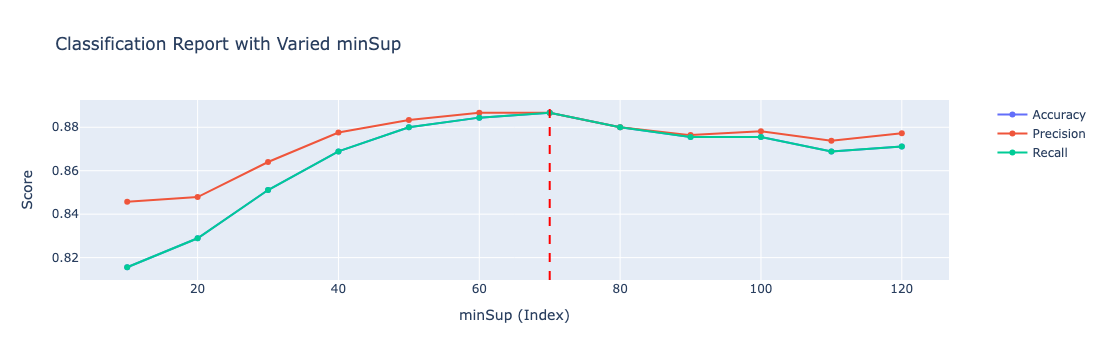

In [108]:
# Create an interactive line chart using Plotly
fig = go.Figure()

# Add lines for accuracy, precision, and recall
fig.add_trace(go.Scatter(x=df.index, y=df['accuracy'], mode='lines+markers', name='Accuracy'))
fig.add_trace(go.Scatter(x=df.index, y=df['precision'], mode='lines+markers', name='Precision'))
fig.add_trace(go.Scatter(x=df.index, y=df['recall'], mode='lines+markers', name='Recall'))

# Add a vertical dashed line at index = 70
fig.add_shape(type='line',
              x0=70, y0=0, x1=70, y1=1, 
              line=dict(color='Red', width=2, dash='dash'),
              xref='x', yref='paper')

# Customize layout
fig.update_layout(
    title='Classification Report with Varied minSup',
    xaxis_title='minSup (Index)',
    yaxis_title='Score',
    legend=dict(x=1.05, y=1),
    showlegend=True
)

# Show the interactive plot
fig.show()